In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from scipy.stats import zscore
import psycopg2
import os
import plotly.express as px
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tabulate
import plotly.graph_objects as go

In [2]:
os.chdir('..')

In [3]:
from db.connection import DatabaseConnection
from db.sql_preprocessor import DBFilter
from src.utils import missing_values_table, find_agg, convert_bytes_to_megabytes, fix_outlier, remove_outliers
from src.plot_utils import set_seaborn_style, plot_histogram_kde, plot_boxplot, plot_time_series, plot_countplot, create_table

In [4]:
db_connection = DatabaseConnection()
set_seaborn_style()

In [5]:
db_connection.connect()

Connected to the database.


In [6]:
query = "SELECT * FROM xdr_data"
df = db_connection.execute_query(query)

In [7]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [8]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [9]:
duplicates = df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [10]:
# Check for missing values in the original DataFrame df
missing_values_df = missing_values_table(df)
print("Missing Values in df:")
print(missing_values_df)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.
Missing Values in df:
                                          Missing Values  % of Total Values  \
Nb of sec with 37500B < Vol UL                    130254               86.8   
Nb of sec with 6250B < Vol UL < 37500B            111843               74.6   
Nb of sec with 125000B < Vol DL                    97538               65.0   
TCP UL Retrans. Vol (Bytes)                        96649               64.4   
Nb of sec with 31250B < Vol DL < 125000B           93586               62.4   
Nb of sec with 1250B < Vol UL < 6250B              92894               61.9   
Nb of sec with 6250B < Vol DL < 31250B             88317               58.9   
TCP DL Retrans. Vol (Bytes)                        88146               58.8   
HTTP UL (Bytes)                                    81810               54.5   
HTTP DL (Bytes)                                    81474               54.3   
Avg RTT DL (ms)       

In [12]:
# XDR analysis

In [13]:
# Using mean values for null fields

In [14]:
db_filter = DBFilter(df)

In [15]:
filtered_numeric_df = db_filter.filter_numeric_columns(threshold=50)

In [16]:
columns_to_exclude = ['Bearer Id', 'Start', 'End', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Handset Manufacturer', 'Handset Type']
for column in df.columns:
    if column not in columns_to_exclude:
        df[column].fillna(df[column].mean(), inplace=True)

In [17]:
# Convert 'Start' and 'End' columns to datetime
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

# Calculate session duration
df['Session Duration (ms)'] = (df['End'] - df['Start']).dt.total_seconds() * 1000

# Calculate total traffic for each session (download + upload)
df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# Group by 'MSISDN/Number' to calculate metrics for each user
user_engagement = df.groupby('MSISDN/Number').agg({
    'Start': 'count',                           # Sessions frequency
    'Session Duration (ms)': 'mean',           # Average session duration
    'Total Traffic (Bytes)': 'sum'             # Total traffic for all sessions
})

# Rename columns for better readability
user_engagement = user_engagement.rename(columns={
    'Start': 'Sessions Frequency',
    'Session Duration (ms)': 'Average Session Duration (ms)',
    'Total Traffic (Bytes)': 'Total Traffic (Bytes)'
})

# Display the result
print(user_engagement)

               Sessions Frequency  Average Session Duration (ms)  \
MSISDN/Number                                                      
3.360100e+10                    1                    116760000.0   
3.360100e+10                    1                    181260000.0   
3.360100e+10                    1                    135000000.0   
3.360101e+10                    1                     49920000.0   
3.360101e+10                    2                     18600000.0   
...                           ...                            ...   
3.379000e+10                    1                      8760000.0   
3.379000e+10                    1                    141000000.0   
3.197021e+12                    1                    877380000.0   
3.370000e+14                    1                    253020000.0   
8.823971e+14                    1                    869820000.0   

               Total Traffic (Bytes)  
MSISDN/Number                         
3.360100e+10            8.786906e+08 

In [18]:
# Report the top 10 customers for each engagement metric
top_10_sessions_frequency = user_engagement.nlargest(10, 'Sessions Frequency')
top_10_average_duration = user_engagement.nlargest(10, 'Average Session Duration (ms)')
top_10_total_traffic = user_engagement.nlargest(10, 'Total Traffic (Bytes)')

# Display the results
print("Top 10 Customers by Sessions Frequency:")
print(top_10_sessions_frequency)

print("\nTop 10 Customers by Average Session Duration:")
print(top_10_average_duration)

print("\nTop 10 Customers by Total Traffic:")
print(top_10_total_traffic)

Top 10 Customers by Sessions Frequency:
               Sessions Frequency  Average Session Duration (ms)  \
MSISDN/Number                                                      
3.362632e+10                   18                   4.884600e+08   
3.361489e+10                   17                   5.863059e+08   
3.362578e+10                   17                   1.091396e+09   
3.365973e+10                   16                   2.522025e+08   
3.367588e+10                   15                   3.243760e+08   
3.376054e+10                   15                   6.186440e+08   
3.366716e+10                   13                   6.726600e+08   
3.360313e+10                   12                   5.240000e+08   
3.360452e+10                   12                   4.340050e+08   
3.362708e+10                   12                   3.919550e+08   

               Total Traffic (Bytes)  
MSISDN/Number                         
3.362632e+10            7.971167e+09  
3.361489e+10            8.

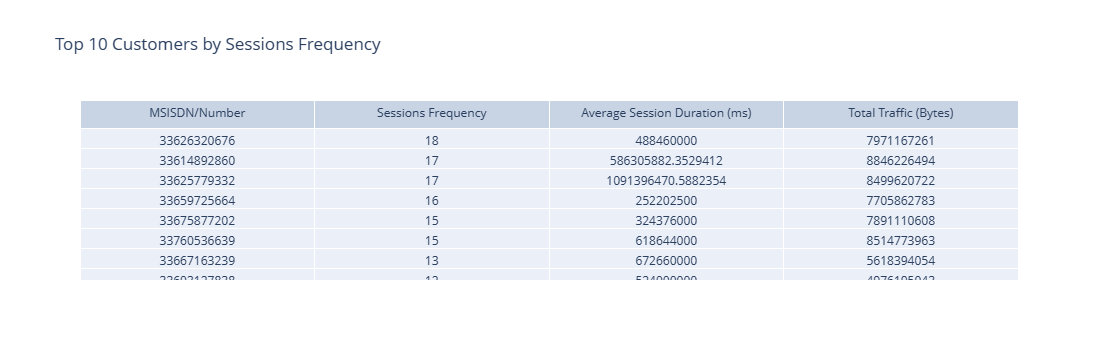

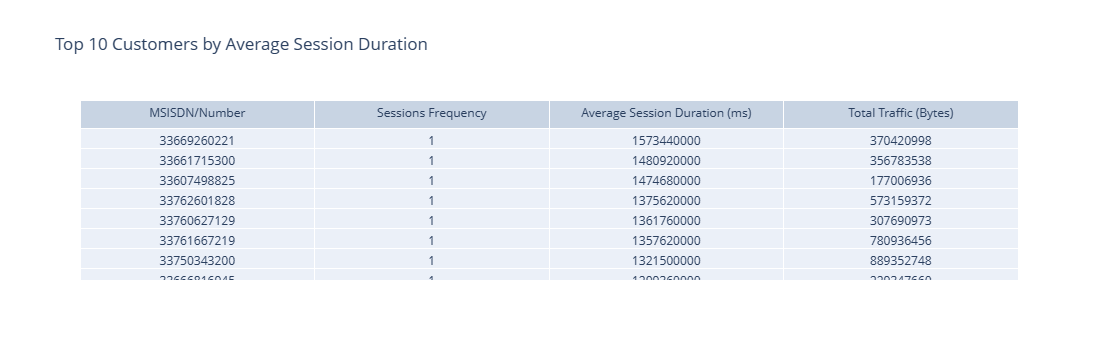

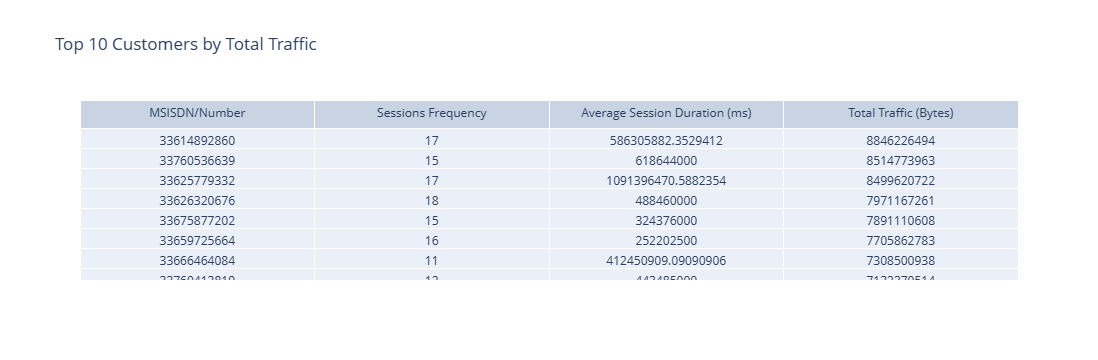

In [36]:
# Reset the index for top 10 customers dataframes
top_10_sessions_frequency_data = top_10_sessions_frequency.reset_index()
top_10_average_duration_data = top_10_average_duration.reset_index()
top_10_total_traffic_data = top_10_total_traffic.reset_index()

# Define the data for the top 10 customers
top_10_sessions_frequency_data = top_10_sessions_frequency_data[['MSISDN/Number', 'Sessions Frequency', 'Average Session Duration (ms)', 'Total Traffic (Bytes)']]
top_10_average_duration_data = top_10_average_duration_data[['MSISDN/Number', 'Sessions Frequency', 'Average Session Duration (ms)', 'Total Traffic (Bytes)']]
top_10_total_traffic_data = top_10_total_traffic_data[['MSISDN/Number', 'Sessions Frequency', 'Average Session Duration (ms)', 'Total Traffic (Bytes)']]

def create_full_table(dataframe, title):
    fig = go.Figure(data=[go.Table(
        header=dict(values=dataframe.columns),
        cells=dict(values=dataframe.transpose().values.tolist())
    )])
    fig.update_layout(title=title)
    return fig

# Create tables using plotly
fig_sessions_frequency = create_full_table(top_10_sessions_frequency_data, "Top 10 Customers by Sessions Frequency")
fig_average_duration = create_full_table(top_10_average_duration_data, "Top 10 Customers by Average Session Duration")
fig_total_traffic = create_full_table(top_10_total_traffic_data, "Top 10 Customers by Total Traffic")

# Show the tables
fig_sessions_frequency.show()
fig_average_duration.show()
fig_total_traffic.show()

In [19]:
# Normalize the engagement metrics
scaler = StandardScaler()
normalized_engagement = scaler.fit_transform(user_engagement)

# Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['Cluster'] = kmeans.fit_predict(normalized_engagement)

# Display the results
print("Customers Classified into 3 Groups of Engagement:")
print(user_engagement)

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Customers Classified into 3 Groups of Engagement:
               Sessions Frequency  Average Session Duration (ms)  \
MSISDN/Number                                                      
3.360100e+10                    1                    116760000.0   
3.360100e+10                    1                    181260000.0   
3.360100e+10                    1                    135000000.0   
3.360101e+10                    1                     49920000.0   
3.360101e+10                    2                     18600000.0   
...                           ...                            ...   
3.379000e+10                    1                      8760000.0   
3.379000e+10                    1                    141000000.0   
3.197021e+12                    1                    877380000.0   
3.370000e+14                    1                    253020000.0   
8.823971e+14                    1                    869820000.0   

               Total Traffic (Bytes)  Cluster  
MSISDN/Number    

In [20]:
# Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['Cluster'] = kmeans.fit_predict(user_engagement)

# Compute metrics for each cluster
cluster_metrics = user_engagement.groupby('Cluster').agg({
    'Sessions Frequency': ['min', 'max', 'mean', 'sum'],
    'Average Session Duration (ms)': ['min', 'max', 'mean', 'sum'],
    'Total Traffic (Bytes)': ['min', 'max', 'mean', 'sum']
})

# Display the results
print("Metrics for Each Cluster:")
print(cluster_metrics)

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Metrics for Each Cluster:
        Sessions Frequency                      Average Session Duration (ms)  \
                       min max      mean    sum                           min   
Cluster                                                                         
0                        1   4  1.060488  52334                     7140000.0   
1                        2  18  3.127905  30153                    10640000.0   
2                        1   6  1.388180  66448                     7140000.0   

                                                  Total Traffic (Bytes)  \
                  max          mean           sum                   min   
Cluster                                                                   
0        1.573440e+09  1.029785e+08  5.081885e+12          3.324901e+07   
1        1.209660e+09  1.106356e+08  1.066527e+12          1.332713e+09   
2        1.357620e+09  1.008044e+08  4.825204e+12          5.798369e+08   

                                    

In [21]:
# List of application columns
app_columns = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)', 
               'Google DL (Bytes)', 'Google UL (Bytes)',
               'Email DL (Bytes)', 'Email UL (Bytes)',
               'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
               'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
               'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
               'Other DL (Bytes)', 'Other UL (Bytes)']

# Calculate total traffic per application
df['Total Social Media Traffic (Bytes)'] = df['Social Media DL (Bytes)'] + df['Social Media UL (Bytes)']
df['Total Google Traffic (Bytes)'] = df['Google DL (Bytes)'] + df['Google UL (Bytes)']
df['Total Email Traffic (Bytes)'] = df['Email DL (Bytes)'] + df['Email UL (Bytes)']
df['Total Youtube Traffic (Bytes)'] = df['Youtube DL (Bytes)'] + df['Youtube UL (Bytes)']
df['Total Netflix Traffic (Bytes)'] = df['Netflix DL (Bytes)'] + df['Netflix UL (Bytes)']
df['Total Gaming Traffic (Bytes)'] = df['Gaming DL (Bytes)'] + df['Gaming UL (Bytes)']
df['Total Other Traffic (Bytes)'] = df['Other DL (Bytes)'] + df['Other UL (Bytes)']

# List of total traffic columns per application
total_traffic_columns = ['Total Social Media Traffic (Bytes)', 'Total Google Traffic (Bytes)',
                         'Total Email Traffic (Bytes)', 'Total Youtube Traffic (Bytes)',
                         'Total Netflix Traffic (Bytes)', 'Total Gaming Traffic (Bytes)',
                         'Total Other Traffic (Bytes)']

# Group by 'MSISDN/Number' to calculate total traffic for each user per application
user_total_traffic = df.groupby('MSISDN/Number')[total_traffic_columns].sum()

# Create a new column for the total traffic across all applications
user_total_traffic['Total Traffic (Bytes)'] = user_total_traffic[total_traffic_columns].sum(axis=1)

# Identify the top 10 most engaged users per application
top_10_users_per_app = {}
for app_column in total_traffic_columns:
    top_10_users = user_total_traffic.nlargest(10, app_column)
    top_10_users_per_app[app_column] = top_10_users

# Display the results
for app_column, top_10_users in top_10_users_per_app.items():
    print(f"\nTop 10 Users for {app_column}:")
    print(top_10_users)


Top 10 Users for Total Social Media Traffic (Bytes):
               Total Social Media Traffic (Bytes)  \
MSISDN/Number                                       
3.362632e+10                           43374779.0   
3.376054e+10                           39783189.0   
3.365973e+10                           35412358.0   
3.361489e+10                           28294544.0   
3.362578e+10                           27135500.0   
3.366716e+10                           24247850.0   
3.378632e+10                           23974919.0   
3.366907e+10                           23800834.0   
3.360313e+10                           23077825.0   
3.365849e+10                           23000066.0   

               Total Google Traffic (Bytes)  Total Email Traffic (Bytes)  \
MSISDN/Number                                                              
3.362632e+10                    152191852.0                   42418782.0   
3.376054e+10                    123223099.0                   33693767.0   
3.365

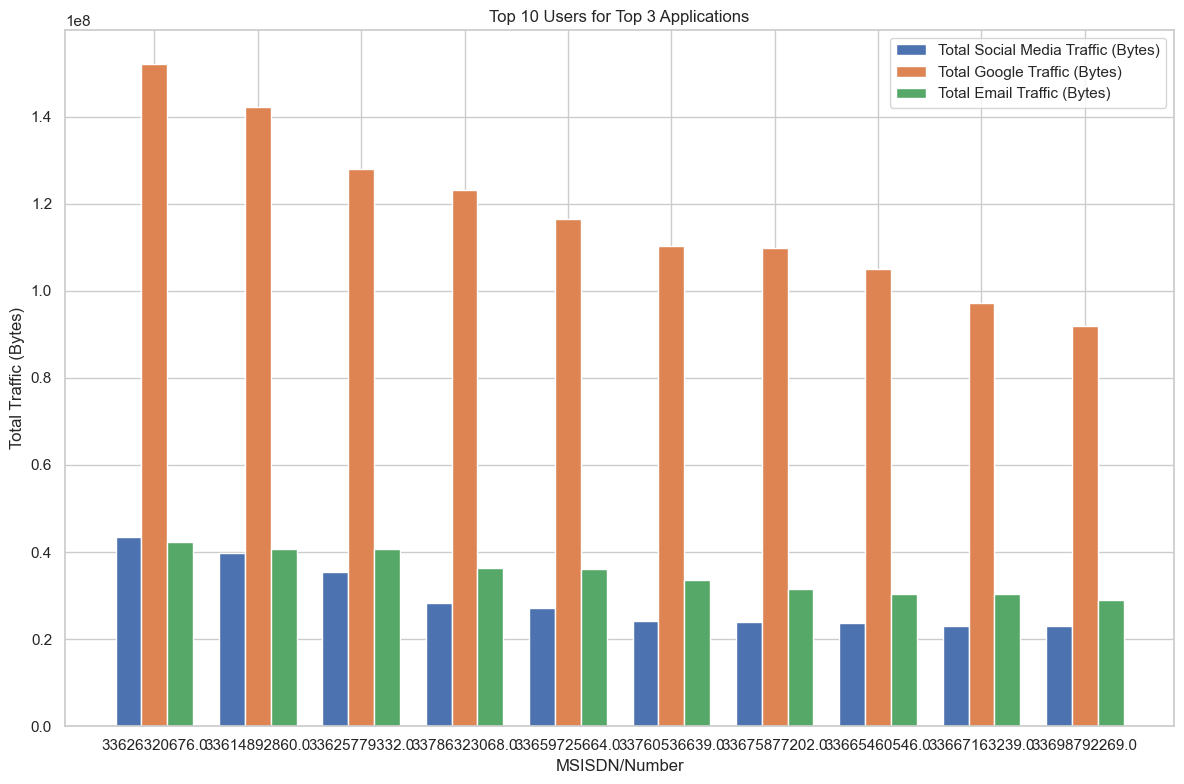

In [22]:
I 

C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy-Week-1\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abel\Documents\10 Academy\Week-1\10-Academy

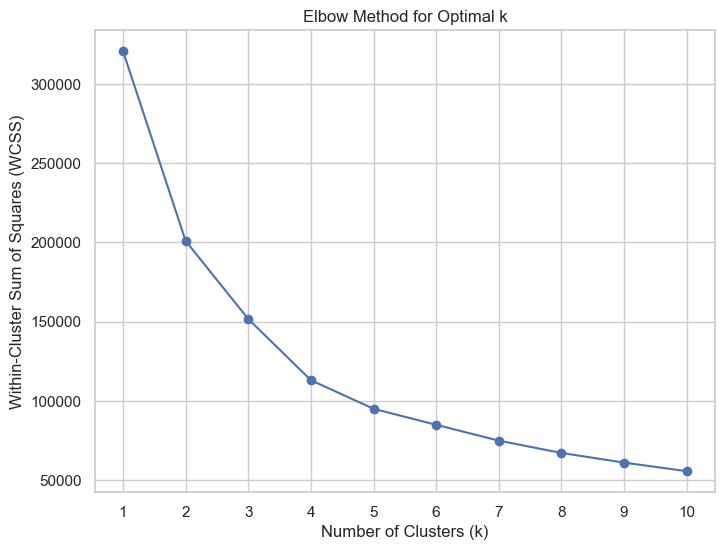

In [23]:
# Select the engagement metrics columns for clustering
engagement_metrics = user_engagement[['Sessions Frequency', 'Average Session Duration (ms)', 'Total Traffic (Bytes)']]

# Normalize the engagement metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics)

# Initialize a list to store the within-cluster sum of squares for each k
wcss = []

# Try k from 1 to 10 (you can adjust the range as needed)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()